In [41]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text
import numpy as np

import nfl_data_py as nfl


In [42]:
# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

In [43]:
years = range(1999, 2023)

In [44]:
columns = ['season', 'posteam', 'play', 'season_type', 'play_type', 'rusher', 'rusher_id', 'game_date']

In [45]:
data = nfl.import_pbp_data(years, cache=True, alt_path='../cache', columns=columns)

data = data[columns]

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [46]:
ids = nfl.import_ids()

ids = ids[['gsis_id', 'name', 'position', 'birthdate']]

In [47]:
df = data.copy()

In [48]:
df = df[(df['play_type'] == 'run') & (df['season_type'] == 'REG') & (df['play'] == 1)]

In [49]:
# Drop plays where the rusher or rusher_id is null
df = df.dropna(subset=['rusher', 'rusher_id'])

In [50]:
# Merge in the player's birthdate
df = df.merge(ids, how='left', left_on='rusher_id', right_on='gsis_id')

In [51]:
# Get the age of the player on the date of the game
df['age'] = (pd.to_datetime(df['game_date']) - pd.to_datetime(df['birthdate'])).dt.days / 365.25

In [52]:
df = df[df['season'] >= 2009]

In [53]:
# where does the null data end?
df = df[df['age'].notnull()]

In [54]:
df = df[df['position'] == 'RB']

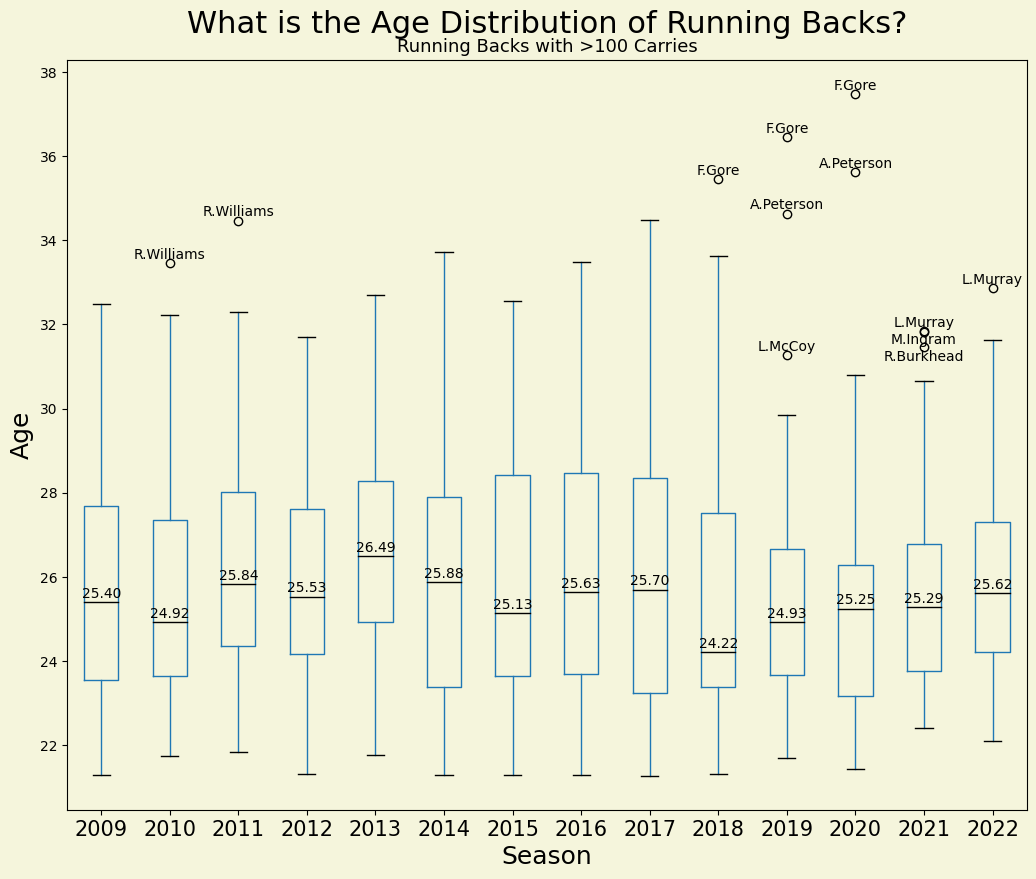

In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text

# Calculate the number of carries and average age per player per season
df_grouped = df.groupby(['season', 'rusher']).agg(
    {'age': 'mean', 'play': 'count'}).reset_index()

# Rename 'play' column to 'carries'
df_grouped = df_grouped.rename(columns={'play': 'carries'})

# Filter players who had more than 100 carries in a season
df_grouped_filtered = df_grouped[df_grouped['carries'] > 100]

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 10))

bp = df_grouped_filtered.boxplot(
    column='age', by='season', grid=False, ax=ax, return_type='dict')

# Change color of median line to black
for median in bp['age']['medians']:
    median.set(color='black')

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Titles and labels
plt.suptitle('What is the Age Distribution of Running Backs?',
             fontsize=22, y=0.95, ha='center')
plt.title("Running Backs with >100 Carries", fontsize=13, y=1.0, ha='center')
plt.ylabel('Age', fontsize=18)
plt.xlabel('Season', fontsize=18)
plt.xticks(fontsize=15)

# Calculate outliers
outliers = []
texts = []
for i in range(len(bp['age']['boxes'])):
    box = bp['age']['boxes'][i].get_ydata()
    Q1 = box[0]
    Q3 = box[2]
    IQR = Q3 - Q1

    # Identify outliers
    outliers = df_grouped_filtered[(df_grouped_filtered['season'] == df_grouped_filtered['season'].unique()[i]) &
                                   ((df_grouped_filtered['age'] < (Q1 - 1.5 * IQR)) |
                                    (df_grouped_filtered['age'] > (Q3 + 1.5 * IQR)))]

    # Annotate medians
    median = bp['age']['medians'][i].get_ydata()[0]
    texts.append(ax.text(
        i+1, median, f"{median:.2f}", va='center', ha='center', color='black', fontsize=10))

    # Annotate outliers
    for j in range(len(outliers)):
        texts.append(ax.text(
            i+1, outliers['age'].values[j], f"{outliers['rusher'].values[j]}", color='black', ha='center', va='center', fontsize=10))

# Adjust the position of non-overlapping annotations
if texts:
    adjust_text(texts, autoalign='y', only_move={'points': 'y', 'text': 'y'})

# Save the plot as a high-quality image
plt.savefig('../images/boxplotRBsAgeBySeason.png',
            dpi=300, bbox_inches='tight')

plt.show()


In [56]:
df_grouped[df_grouped['rusher'] == 'N.Bellore']

,season,rusher,age,carries
1236,2018,N.Bellore,29.500342,1
1527,2020,N.Bellore,31.474333,1
1832,2022,N.Bellore,33.659138,1
